<a href="https://colab.research.google.com/github/shblanco/Second-stage-of-the-project/blob/main/Project_III_Etapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica | TEC
# Carrera de Ingeniería en Computación 
# I Semestre de 2023
# Proyecto Programado (III Fase – Entrevistador asistido por IA) 
# Dr. Abel Méndez Porras
# amendez@itcr.ac.cr
# Porcentaje: 20%

# Entrevistador asistido por IA



El reconocimiento facial y la detección de emociones son tecnologías que se han vuelto cada vez más populares en los últimos años. Estas tecnologías utilizan algoritmos de inteligencia artificial para analizar imágenes y detectar patrones faciales que permiten identificar a las personas y sus emociones.
En cuanto a las oportunidades, el reconocimiento facial puede tener aplicaciones en la seguridad, el marketing y la atención al cliente. Por ejemplo, en la seguridad se pueden utilizar sistemas de reconocimiento facial para identificar a personas en lugares públicos o para controlar el acceso a edificios y sistemas de seguridad. En el marketing, se pueden utilizar para personalizar la publicidad en función de la edad, el género y otros datos demográficos. Y en la atención al cliente, se pueden utilizar para detectar la satisfacción del cliente en tiempo real y responder adecuadamente.

En esta tercera fase del proyecto del curso de Taller de Programación estaremos utilizando los resultados de consultas a modelos de Deep Learning para aplicar los conocimientos adquiridos en clase. Estaremos utilizando los requerimientos desarrollados para la segunda fase del proyecto. Sin embargo, se estarán utilizando widgets para hacer la recolección y mostrar la información para cada requerimiento desarrollado en la segunda fase. Además, se incluyen el manejo de árboles binarios para hacer busqueda de información. 

## Objetivo
Desarrollar una aplicación de complejidad baja que permita poner en práctica los conocimientos adquiridos en los cursos de Introducción a la Programación y Taller de Programación.

## Objetivos Específicos
*  Identificar los requerimientos para resolver un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos, archivos, árboles binarios y widgets.
*  Diseñar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos, archivos, árboles binarios y widgets.
*  Desarrollar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos, archivos, árboles binarios y widgets.

## Configuración previa 

### Cargar Google Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Leer cámara
Tomado de https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb



### Importar dependencies

In [10]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

### Convertir el objeto JavaScript un objeto OpenCV image

In [11]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Crear nuestro live video stream

In [4]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Iniciar streaming video

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [13]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import model_from_json

### Cargar modelos de Deep Learning entrenados

*   Para detectar los rostros se utiliza el modelo de Face Haar Cascade.
*   Para detectar las emociones se utiliza el modelo de VGG.
*   También se utiliza un algoritmo adicional para pasar la información del algortimo de VGG a un formato JSON.

Estos modelos y algoritmos están disponibles en el siguiente enlace [Descargar modelos y algoritmos](https://drive.google.com/drive/folders/1KctA_s25bqqMOUlQuy0lwTm0HkBGVycF?usp=sharing). Usted los debe colocar en su Google Drive y modificar la ruta de acceso. 



In [8]:
#Cargar modelos de Deep Learning entrenados
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/images/haarcascade_frontalface_alt.xml') 
model = model_from_json(open("/content/drive/MyDrive/images/model.json", "r").read()) 
model.load_weights('/content/drive/MyDrive/images/model.h5') 


Crear interfaz
https://www.youtube.com/watch?v=oIVmV41uyK8

#Perfiles del Entrevistador Personal

El entrevistador personal es una herramienta para recolectar información de personas que están aplicando a un puesto. En la aplicación existen tres perfiles el entrevistador, el entrevistado y el evaluador. La información de estos perfiles debe ser almacenada en clases y usando herencia. Debe existir una clase "padre" que tiene propiedades y métodos que comparten todos los perfiles. Para cada perfil debe existir una clase subordinada que hereda las propiedades de la clase "padre", además, tiene sus propias propiedades y métodos.

## Recolectar información del entrevistador


El entrevistador es la persona encargada de realizar las entrevistas. 

Información requerida del entrevistador (Toda la información requerida debe ser almacenada en la clase Entrevistador. Cada vez que se registra un entrevistador se debe crear una instancia de la clase Entrevistador para guardar toda la información del entrevistador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al entrevistador.
Cada vez que se crea una instancia de Entrevistador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistador.

## Recolectar información del evaluador

El evaluador en la persona encargada de revisar la información obtenida de cada entrevista. 

Información requerida del evaluador (Toda la información requerida debe ser almacenada en la clase Evaluador. Cada vez que se registra un evaluador se debe crear una instancia de la clase Evaluador para guardar toda la información del evaluador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al evaluador.
Cada vez que se crea una instancia de Evaluador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Evaluador.

## Recolectar información del entrevistado

El entrevistado es la persona que está interesada en el puesto de trabajo.

Información requerida al entrevistar una persona (Toda la información requerida debe ser almacenada en la clase Entrevistado. Cada vez que se registra un entrevistado se debe crear una instancia de la clase Entrevistado para guardar toda la información del entrevistado).
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección
*   Estado civil
*   Cantidad de hijos indicando el género, la fecha de nacimiento(un diccionario) 
*   Entrevistas (cada persona puede ser entrevistada cero o más veces). Las entrevistas se realizan en tiempo real utilizando una camára integrada a la computadora o externa (el profesor facilita el código para activar la camára, capturar el video y capturar los frames cada cierto tiempo). Se debe crear una lista con sublistas donde cada sublista tiene las imagenes capturas y las emociones reportadas durante la entrevista. Además, debe guardar coordenadas donde se encuentra el rostro en la imagen. Para cada entrevista, el entrevistado debe contar historias cortas sobre los siguientes 4 tópicos:


  >*   Una experiencia de sorpresa o asombro que ha tenido que vivir.
  >*   Una experiencia de tristeza que ha tenido que vivir.
  >*   Una experiencia de enojo o frustración que ha tenido que vivir.
  >*   Una experiencia de felicidad que ha tenido que vivir.

Un aspecto importante es que cada vez que se va a realizar una entrevista se debe indicar quién es el entrevistador.

Usted debe incluir al menos tres propiedades únicas al perfil de entrevistado. Cada vez que se crea una instancia de Entrevistado, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistado.

In [ ]:
def show_image(image_path):
  """ This function shows an image.
    Arguments:
        image_path {str} -- Image path. 
  """
  img = cv2.imread(image_path)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()
#Code taken from ordenamientos de "Reconocimiento de Personas" in week 8 of Introducción a la Programación.

In [4]:
class Person():
  def __init__(self, identification, name, birth_date, age, nationality, telephone_numbers, gender, emails, address):
    """Forms a instance of a person"""
    self.name = name
    self.identification = identification
    self.birth_date = birth_date
    self.age = age
    self.nationality = nationality
    self.telephone_numbers = telephone_numbers 
    self.gender = gender
    self.emails = emails
    self.address = address

class Interviewer(Person):
  """Forms a instance of an interviewer and enherits the class named Person"""
  def __init__(self, identification, name, birth_date, age, nationality, telephone_numbers, gender, emails, address, code_number, certificate, experience):
   super().__init__(identification, name, birth_date, age, nationality, telephone_numbers, gender, emails, address)
   self.code_number = code_number
   self.certificate = certificate
   self.experience = experience
  def __str__(self):
    """This method is for printing the instance information"""
    return f"name: {self.name}, identitification: {self.identification}, birth_date: {self.birth_date}, age: {self.age}, nationality: {self.nationality}, telephone_numbers: {self.telephone_numbers}, gender: {self.gender}, emails: {self.emails}, address: {self.address}, code_number: {self.code_number}, certificate: {self.certificate}, experience: {self.experience}"



class Evaluator(Person):
  def __init__(self, identification, name, birth_date, age, nationality, telephone_numbers, gender, emails, address, specialty, technical_programs, languages):
   """Forms a instance of an evaluator and enherits the class named Person"""
   super().__init__(identification, name, birth_date, age, nationality, telephone_numbers, gender, emails, address)
   self.specialty = specialty
   self.technical_programs = technical_programs
   self.languages = languages
  def __str__(self):
    """This method is for printing the instance information"""
    return f"name: {self.name}, identitification: {self.identification}, birth_date: {self.birth_date}, age: {self.age}, nationality: {self.nationality}, telephone_numbers: {self.telephone_numbers}, gender: {self.gender}, emails: {self.emails}, address: {self.address}, specialty: {self.specialty}, technical_programs: {self.technical_programs}, languages: {self.languages}"





class Interviewee(Person):
  def __init__(self, identification, name, birth_date, age, nationality, telefone_numbers, gender, emails, address, marital_status, children, job, salary, academic_grade, state, images):
   """Forms a instance of an interviewee and enherits the class named Person"""
   super().__init__(identification, name, birth_date, age, nationality, telefone_numbers, gender, emails, address)
   self.marital_status = marital_status
   self.children = children
   self.job = job
   self.salary = salary
   self.academic_grade = academic_grade
   self.state = state
   self.images = images
  def __str__(self):
    """This method is for printing the instance information"""
    return f"name: {self.name}, identitification: {self.identification}, birth_date: {self.birth_date}, age: {self.age}, nationality: {self.nationality}, telephone_numbers: {self.telephone_numbers}, gender: {self.gender}, emails: {self.emails}, address: {self.address}, marithal_status: {self.marital_status}, children: {self.children}, job: {self.job}, salary: {self.salary}, academic_grade: {self.academic_grade}, state: {self.state}, images: {self.images}"


### Recolectar información emociones
Este código se encarga de ejecutar la captura de video de la cámara, detectar los rostros en las imágenes y reconocer las emociones presentes en los rostros. Cuando se hace la entrevista es en este código donde usted de obtener la información para crear las listas con la información solicitada.

In [13]:
import pickle
j = 5
with open("/content/drive/MyDrive/Archive_III_project/Archivo_j", "wb") as entre:
    pickle.dump(j, entre)

<IPython.core.display.Javascript object>

Ubicación del rostro: ()


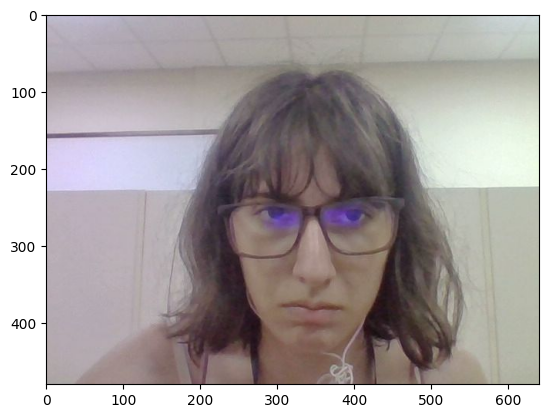

Ubicación del rostro: ()


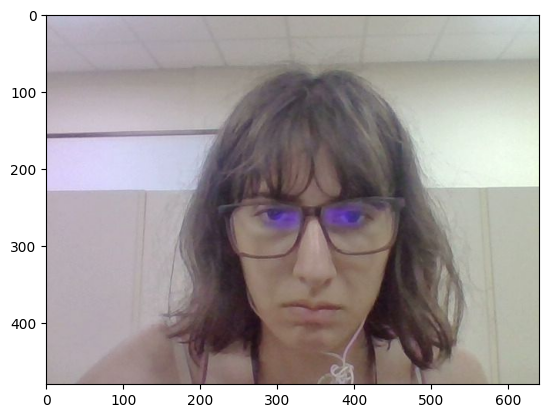

Ubicación del rostro: ()


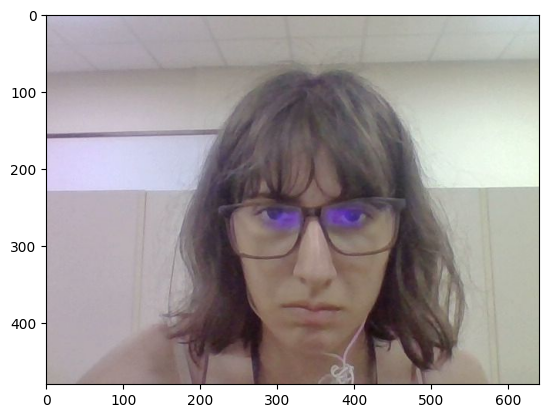

Ubicación del rostro: ()


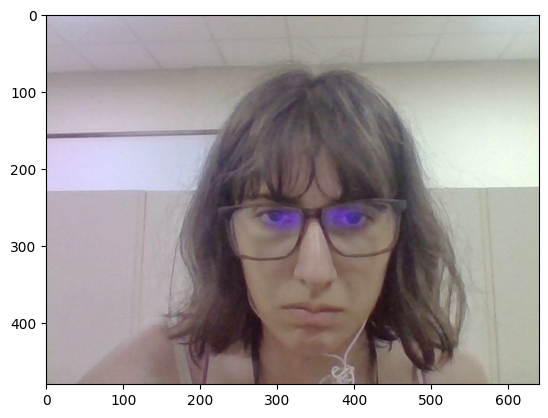

Ubicación del rostro: ()


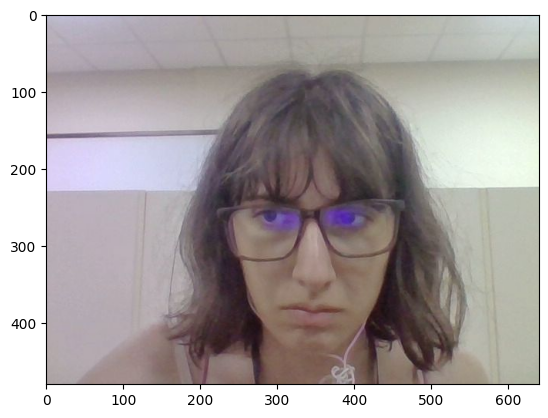

In [14]:
from tensorflow.python.ops.math_ops import sign
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
listn = []
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  img_copy = img

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)
  with open("/content/drive/MyDrive/Archive_III_project/Archivo_j", "rb") as entre:
   j = pickle.load(entre)

  if count == j: #El tiempo para capturar el frame y procesarlo
    #Este sería el path de la imagen guardada
    image_path ='/content/drive/MyDrive/Frames_III_Project' + 'nombre' + str(j) +  '.jpg'
    #se guarda el fotograma con el "nombre" más el número del contador i
    cv2.imwrite(image_path , img) 
    
    #Detectar los rostros usando Face Haar Cascade
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #En faces_deteted se encuentran los rotros detectados
    faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.32,5)
    #Imprimir ubicación de los rostros en la imagen
    print("Ubicación del rostro:", faces_detected)
    im2Display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imTemp = im2Display.copy()
    listn.append([faces_detected])
    listn.append(image_path)
    #Hacer un rectángulo en cada rostro detectado en la imagen
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(img,(x,y), (x+w,y+h), (255,0,0), thickness=7)

        roi_gray=gray_image[y:y+w,x:x+h]
        roi_gray=cv2.resize(roi_gray,(48,48))

        #Processes the image and adjust it to pass it to the model
        image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
       
        image_pixels = np.expand_dims(image_pixels, axis = 0)
        image_pixels /= 255

        #Obtener las emociones para cada rostro detectado en la imagen
        #Get the prediction of the model
        predictions = model.predict(image_pixels)
        #Mostrar todas las emociones detectadas
        print("Predicciones: ", predictions)
        #Mostrar la emoción más significativa (con el valor más alto)
        max_index = np.argmax(predictions[0])
        print(max_index, predictions[0])
        #El orden en que vienen las emociones
        emotion_detection = ('angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral')

        emotion_prediction = emotion_detection[max_index]
        #Crear un diccionario para almacenar la emoción y el valor para la emoción
        frame_dic = dict(
            angry = predictions[0][0],
            disgust = predictions[0][1],
            fear = predictions[0][2],            
            happiness = predictions[0][3],
            sadness = predictions[0][4],
            surprise = predictions[0][5],
            neutral = predictions[0][6]) 
        print("Predicciones: ", frame_dic)
        listn.append(frame_dic)
        print( emotion_prediction )
        
        #Mostrar en la imagen un texto de la emoción más significativa
        ubicacion = (x,y)
        font = cv2.FONT_HERSHEY_TRIPLEX
        tamañoLetra = 2
        colorLetra = (221,82,196)
        grosorLetra = 7
        #Escribir texto con la emoción más significativa
        cv2.putText(imTemp, emotion_prediction, ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        pt1 = (x, y)
        pt2 = (x+w, y+h)
        color = (23,200,54)
        thickness = 10
        cv2.rectangle(imTemp, pt1, pt2, color, thickness)

    #Mostrar la imagen con los cuadros en los rostros y el texto de la emoción más significativa
    plt.imshow(imTemp)
    plt.show()
    j +=5
    with open("/content/drive/MyDrive/Archive_III_project/Archivo_j", "wb") as entre:
      pickle.dump(j, entre)
  count +=1

# Objetos Gráficos



1.   Debe implementar Widgets para la información a recolectar y mostrar para cada uno de los requerimientos del proyecto. A continuación, se listan los principales tipos de widgets que debe utilizar en el proyecto.
  

    *   Numeric widgets
    *   Boolean widgets
    *   Selection widgets
    *   String widgets
    *   Image
    *   Tag widgets
    *   Date picker
    *   Time picker
    *   Color picker
    *   File Upload
    *   Container/Layout widgets



In [7]:
empty_list = []

In [14]:
with open("/content/drive/MyDrive/Archive_III_project/Archivo_Evaluador", "wb") as entre:
      pickle.dump(empty_list, entre)

In [17]:
with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistador", "wb") as entre:
      pickle.dump(empty_list, entre)

In [18]:
with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistado", "wb") as entre:
      pickle.dump(empty_list, entre)

In [20]:
from ipywidgets.widgets.domwidget import InstanceDict
import pickle
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

#----------------------------------------function to save the evaluator instances-----------------------------------------
def archive_evaluator(Instance):
 """The function saves the evaluator instance in a pickle archive.
    Arguments:
        Instance {str} -- Instance.
 """
 with open("/content/drive/MyDrive/Archive_III_project/Archivo_Evaluador", "rb") as entre:
    Archive_evaluator = pickle.load(entre)
 for x in Archive_evaluator:
    if x.identification == Instance.identification:
       Archive_evaluator.remove(x)
 Archive_evaluator.append(Instance)
 with open("//content/drive/MyDrive/Archive_III_project/Archivo_Evaluador", "wb") as entre:
      pickle.dump(Archive_evaluator, entre)
 print("The information has been saved")


#----------------------------------------function to save the interviewer instances-----------------------------------------
def archive_interviwer(Instance):
 """The function saves the interviewer instance in a pickle archive.
    Arguments:
        Instance {str} -- Instance.
 """
 with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistador", "rb") as entre:
    Archive_interviewer = pickle.load(entre)
 for x in Archive_interviewer:
    if x.identification == Instance.identification:
       Archive_interviewer.remove(x)
 Archive_interviewer.append(Instance)
 with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistador", "wb") as entre:
      pickle.dump(Archive_interviewer, entre)
 print("The information has been saved")


#----------------------------------------function to save the interviewer instances-----------------------------------------
def archive_interviewee(Instance):
 """The function saves the interviewee instance in a pickle archive.
    Arguments:
        Instance {str} -- Instance.
 """
 with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistado", "rb") as entre:
    Archive_interviewee = pickle.load(entre)
 for x in Archive_interviewee:
    if x.identification == Instance.identification:
       Archive_interviewee.remove(x)
 Archive_interviewee.append(Instance)
 with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistado", "wb") as entre:
      pickle.dump(Archive_interviewee, entre)
 print("The information has been saved")



def evaluator():
 """This function creates an evaluator instance using widgets. 
 """
 #Code to ask all the individual's information
 name = widgets.Text(
    value='Place your name',
    placeholder='Type something',
    description='Name:',
    disabled=False
 )
 ID = widgets.BoundedIntText(
    placeholder='Place your identification',
    description='ID:',
    disabled=False
 )
 birth_date = widgets.DatePicker(
    description='Birth date: ',
    disabled=False
 )
 age = widgets.BoundedIntText(
    value=0,
    min=0,
    max=200,
    step=1,
    description='Age: ',
    disabled=False
 )
 nationality = widgets.Text(
    value='Place your nationality',
    placeholder='Type something',
    description='Nationality:',
    disabled=False
 )
 telephone = widgets.BoundedIntText(
    value=0,
    min=0,
    max=200,
    step=1,
    description='Telephone: ',
    disabled=False
 )
 gender =  size = widgets.Dropdown(
    options=['female', 'male'],
    value='male',
    description='Gender: ',
    disabled=False,
 )
 email =  widgets.Text(
    value='Place your email',
    placeholder='Type something',
    description='Email:',
    disabled=False
 )
 address = widgets.Text(
    value='Place your address',
    placeholder='Type something',
    description='Address:',
    disabled=False
 )
 specialty = widgets.Text(
    value='Place your specialty',
    placeholder='Type something',
    description='Specialty:',
    disabled=False
 )
 technical_programs = widgets.Text(
    value='Place your technical programs',
    placeholder='Type something',
    description='Programs:',
    disabled=False
 )
 languages = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Languages:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
 boton = widgets.Button(
    description = "Save information"
 )
 container = widgets.VBox([name, ID , birth_date, age, nationality, telephone, gender, email, address, specialty, technical_programs, languages, boton])
 def savedata(b):
   Person = Evaluator(name.value, ID.value, birth_date.value, age.value, nationality.value, telephone.value, gender.value, email.value, address.value, specialty.value, technical_programs.value, languages.value)
   archive_evaluator(Person)
 boton.on_click(savedata)
 display(container)

evaluator()



The information has been saved


In [ ]:
#Menu to create new instances
while True:
 print("What is your profile?: ")
 print("\nEvaluator 1","\nInterviewer 2","\nInterviewee 3","\nFinish 0" )
 print("Place your profile number")

 v = int(input())
 if v == 1:
   evaluator()
 elif v == 2:
   interviewer()
 elif v == 3:
   interviewee()
 elif v == 0:
  break
 else:
  print("Error, place a number given by the menu")
   

In [21]:
#Library pickle to save archives.
import pickle
with open("/content/drive/MyDrive/Archive_III_project/Archivo_Evaluador", "rb") as entre:
    Archive_evaluator = pickle.load(entre)
for x in Archive_evaluator:
  print(x)
print("---------")
with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistador", "rb") as entre:
  Archive_interviewer = pickle.load(entre)
for x in Archive_interviewer:
    print(x)
#with open("/content/drive/MyDrive/Archive_III_project/Archivo_Entrevistado", "rb") as entre:
 # Archive_interviewee = pickle.load(entre)
#print("---------")
#for x in Archive_interviewee:
 # print(x)

name: 0, identitification: Place your name, birth_date: None, age: 0, nationality: Place your nationality, telephone_numbers: 0, gender: male, emails: Place your email, address: Place your address, specialty: Place your specialty, technical_programs: Place your technical programs, languages: 7
---------


# Árboles binarios


1.   Implementar un árbol binario para almacenar de forma ordenada las personas por edad (Cada nodo del árbol debe contener una instancia de la clase Entrevistado).
2.   Implementar un árbol binario para almacenar de forma ordenada las personas por por la emoción de felicidad (Cada nodo del árbol debe contener una instancia de la clase Entrevistado).

3. Implementar una función que muestre la información del árbol implementado en el punto 1 en orden (Debe mostrar la información usando widgets).


4. Implementar una función que muestre la información del árbol implementado en el punto 2 en preorden (Debe mostrar la información usando widgets).


5. Implementar una función que buscar una persona por la identificación en el árbol implementado en el punto 1. 

6. Implementar una función que buscar una persona por el nombre en el árbol implementado en el punto 2.

7. Implementar una función que buscar muestre todas las personas que tienen el grado de felicidad más alto en el árbol implementado en el punto 1. 

# Consultas


1.   Mostrar la información de todas las personas entrevistas (la información debe ser mostrada siendo saca del archivo correspondiente, debe mostrar la información en formato legible, no en estructuras y objetos). Además, debe mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

2.   Mostrar la información de todas las personas entrevistas ordenada ascendentemente por edad. El método de ordenamiento a utilizar es el método por inserción (la información debe ser mostrada siendo saca de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

3.   Mostrar la información de todas las personas entrevistas ordenada descendente mente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la bubuja (la información debe ser mostrada siendo saca de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

4. Mostrar la información de todas las personas entrevistas ordenada descendentemente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la quicksort (la información debe ser mostrada siendo sacada de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros. También, imprimir una lista con sublistas donde la primera sublista tiene la información de las personas que tienen únicamente hijos de género femenino, la segunda sublista tiene información de personas que tienen únicamente hijos de género masculino y la última sublista tiene información de personas que tienen hijos tanto de género femenino como másculino. 

5. Obtener para cada persona entrevistada las emociones sin ordenar y guardar en una lista (una lista por entrevista) con sublistas la siguiente información: en la primera sublista colocar la identificación, el nombre, el género y la edad de la persona entrevistada, en las siguientes sublistas colocar las emociones expresadas por la persona. Por ejemplo, si la persona apareció en 10 fotogramas entonces se deben crear 10 sublistas, cada sublista pertenece a las emociones emitidas por el candidato en un fotograma. 

6. Una vez creada esta listas (una por entrevista) con sublistas del punto anterior, se debe ordenar las sublistas de forma ascendente por la emoción felicidad (happiness) utilizando el técnica de ordenamiento Quicksort.

7. Para cada persona entrevistada muestre un gráfico para comparar las emociones reportadas durante la entrevista.

8. Incluya en el documento escrito la entrevista a dos personas. De aportar toda la información recolectada, las imágenes recolectadas en la entrevista con un cuadro en los rostros presentes. Además, debe mostrar la información de las emociones reportadas. También debe mostrar la información del entrevistador y el evaluador.

9. Hacer una nueva entrevista a una persona. Una persona existente (previamente almacena en los archivos) puede volver a ser entrevistada. Debe guardar la nueva entrevista en el mismo archivo agregando la información de esta nueva entrevista a la lista de entrevistas de dicha persona. Tome en cuenta que el entrevistador puede ser uno que no le ha realizado ninguna entrevista.

10. Agregar una evaluación para indicar si la persona será contratada. Una vez que una persona ha sido entrevistada un evaluador puede revisar toda la información y decir si la persona será contratada (Debe mostrar la información de la persona para que el evaluador la revise y debe aportar una propiedad para la persona que se indica llamada "estado" (el estado puede ser entrevistado, contratado y no contratado). Tome en cuenta que el evaluador puede cambiar el estado de la persona para indicar que está contratado o no contratado. 




## Aspectos administrativos


* La tarea será desarrollada en equipos de trabajo de máximo 2 personas.
* Cualquier acción de plagio será sancionada con una nota de 0 y la carta al expediente respectiva para todos los
implicados.
* La fecha de entrega será la semana 17, el día de clases, antes de la hora de clases.
* Para llevar el control de versiones del proyecto se debe crear un repositorio en GitLab y agregar al profesor (agregarlo
a la cuenta amendez.tec@gmail.com).
* Para llevar el control del las tareas a realizar por participante en el proyecto debe utilizar la herramienta
https://trello.com/es y compartir el link en el mismo Google Doc en que se comparte el link de la plantilla de Overleaf. Pueden crear tab de todas las tareas o requerimientos, un tab para las tareas en proceso y un tab para las tareas hechas.
* La codificación y documentación interna deberá ser desarrollada en idioma inglés utilizando el estándar docString de Python.
*La documentación externa debe estar redactada en idioma inglés utilizando la herramienta Overleaf (utilizar la plantilla facilitada por el profesor). La documentación es evaluada en el curso de Introducción a la programación.
* Documentación del Código utilizando Docstring Conventions 	
* Introducción a Python la Guía de Estilo de Código en Python
* La entrega será mediante la plataforma TecDigital en el espacio de Proyecto – Etapa 2. Lo que debe subir es un archivo de tipo notebook cuya extensión es (.ipynb). Además, en este archivo deben venir los enlaces a las imagenes utilizados para la tarea.
* Se recomienda que se empiece a trabajar lo antes posible.



# "La programación es una habilidad que puedes cultivar en ti mismo y usar para cambiar el mundo". - Barack Obama